# News Sentiment as a Factor Influencing Stock Market Volatility (2020–2025)

**Author:** Meyzler Liya Borisovna | Group БПАД241  
**Supervisor:** Bashminova D.A. | HSE University, Faculty of Computer Science

---

## Research Question
> *To what extent does the impact of **negative** news sentiment on stock market volatility **exceed** that of positive sentiment during periods of increased uncertainty (2020–2025)?*

---

## Notebook Structure

| # | Section | Methods |
|---|---------|----------|
| 0 | **Setup & Data Loading** | pandas, imports |
| 1 | **Data Cleaning** | Missing values, duplicates, types, outliers |
| 2 | **Visualizing Features** | Histograms, time series, heatmaps |
| 3 | **Statistical Summaries** | Descriptive stats, correlations, CAPM |
| 4 | **H1: Sentiment Asymmetry** | Welch t-test, Mann–Whitney, OLS (Parkinson vol) |
| 5 | **H2: Crisis Amplification** | Regime-split OLS, interaction model |
| 6 | **H3: Predictive Value of Sentiment** | XGBoost: market-only vs market+sentiment |
| 7 | **Results Summary** | Combined table |

---

### Note
During data cleaning it was discovered that `twitter_sentiment_mean` is **nearly constant** across 94.8% of observations (value = 0.1326) due to excessive forward-filling of a sparse dataset. This column is **excluded from hypothesis testing**. The primary sentiment source is `polygon_sentiment_mean` — 66,000+ news articles from Polygon.io/Massive.com with 1,156 unique daily values. But I will try to fix it.


---
# Section 0 — Setup & Data Loading

In [1]:
!pip install xgboost statsmodels scipy seaborn matplotlib pandas numpy scikit-learn -q

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# ── Colours ───────────────────────────────────────────
PALETTE = {
    'negative': '#C1121F',
    'positive': '#2D6A4F',
    'neutral' : '#6C757D',
    'accent'  : '#F4A261',
    'blue'    : '#4361EE',
    'purple'  : '#7209B7',
    'teal'    : '#2EC4B6',
    'bg'      : '#F8F9FA',
    'dark'    : '#212529',
}

# ── Global style ─────────────────────────────────────────────
plt.rcParams.update({
    'figure.facecolor' : PALETTE['bg'],
    'axes.facecolor'   : 'white',
    'axes.spines.top'  : False,
    'axes.spines.right': False,
    'axes.titlesize'   : 13,
    'axes.labelsize'   : 11,
    'xtick.labelsize'  : 9,
    'ytick.labelsize'  : 9,
    'grid.color'       : '#DEE2E6',
    'grid.linestyle'   : '--',
    'grid.alpha'       : 0.6,
})

print('Imports done')

Imports done


In [4]:
df_raw = pd.read_csv('final_dataset.csv', parse_dates=['date'])
print(f'Shape      : {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns')
print(f'Period     : {df_raw["date"].min().date()} → {df_raw["date"].max().date()}')
print(f'Tickers   : {sorted(df_raw["ticker"].unique())}')
df_raw.head(3)

Shape      : 22,620 rows × 33 columns
Period     : 2020-01-02 → 2025-12-31
Tickers   : ['AAPL', 'AMD', 'AMZN', 'DIS', 'GOOGL', 'GS', 'JNJ', 'JPM', 'META', 'MSFT', 'NFLX', 'NVDA', 'SPY', 'TSLA', 'XOM']


,date,ticker,Open,High,Low,Close,Volume,returns,volatility_21d,parkinson_vol,...,twitter_source,polygon_sentiment_mean,polygon_positive_pct,polygon_negative_pct,polygon_article_count,news_sentiment_mean,news_positive_pct,news_negative_pct,news_count,missing_flags
0,2020-01-02,AAPL,71.409800,72.460799,71.156697,72.400536,135480400,NaN,NaN,NaN,...,StephanAkkerman/stock-market-tweets-data,NaN,NaN,NaN,0,NaN,NaN,NaN,0,"volatility_21d,parkinson_vol,fear_greed_value,..."
1,2020-01-03,AAPL,71.629145,72.455958,71.472462,71.696640,146322800,-0.009770,NaN,NaN,...,StephanAkkerman/stock-market-tweets-data,NaN,NaN,NaN,0,NaN,NaN,NaN,0,"volatility_21d,parkinson_vol,fear_greed_value,..."
2,2020-01-06,AAPL,70.819231,72.306529,70.568532,72.267960,118387200,0.007937,NaN,NaN,...,StephanAkkerman/stock-market-tweets-data,NaN,NaN,NaN,0,NaN,NaN,NaN,0,"volatility_21d,parkinson_vol,fear_greed_value,..."


---
# Section 1 — Data Cleaning
For data cleaning I will follow these steps:
1. **Missing values**
2. **Duplicates**
3. **Data types**
4. **Outliers**

## 1.1 Missing Values

Columns with missing values:


,Missing N,Missing %
twitter_sentiment_mean,1020,4.51%
twitter_negative_pct,1020,4.51%
twitter_sentiment_std,1020,4.51%
twitter_positive_pct,1020,4.51%
fear_greed_label,465,2.06%
fear_greed_value,465,2.06%
fear_greed_numeric,465,2.06%
volatility_21d,315,1.39%
parkinson_vol,300,1.33%
news_positive_pct,165,0.73%


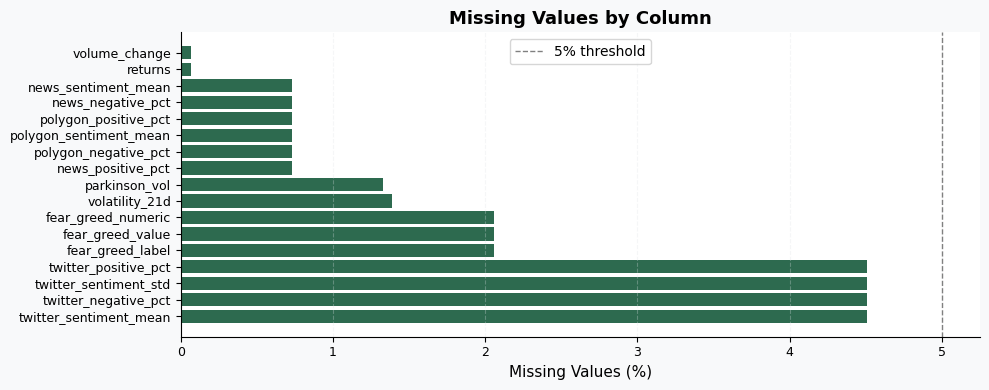

In [6]:
missing_df = pd.DataFrame({
    'Missing N'  : df_raw.isnull().sum(),
    'Missing %'  : (df_raw.isnull().mean() * 100).round(2)
}).query('`Missing N` > 0').sort_values('Missing %', ascending=False)

print('Columns with missing values:')
display(missing_df.style
    .background_gradient(subset=['Missing %'], cmap='Reds')
    .format({'Missing %': '{:.2f}%'})
)

fig, ax = plt.subplots(figsize=(10, 4))
colors = [PALETTE['negative'] if p > 50 else
          PALETTE['accent']   if p > 5  else
          PALETTE['positive'] for p in missing_df['Missing %']]
ax.barh(missing_df.index, missing_df['Missing %'], color=colors)
ax.axvline(5, color='grey', linestyle='--', lw=1, label='5% threshold')
ax.set_xlabel('Missing Values (%)')
ax.set_title('Missing Values by Column', fontweight='bold')
ax.legend(); ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('fig_missing.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:

df = df_raw.copy()
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)


ffill_cols = ['vix', 'treasury_yield', 'fear_greed_value',
              'fear_greed_numeric', 'covid_trend']
for col in ffill_cols:
    if col in df.columns:
        df[col] = df[col].ffill()

sent_cols = ['polygon_sentiment_mean', 'polygon_positive_pct', 'polygon_negative_pct',
             'news_sentiment_mean', 'news_positive_pct', 'news_negative_pct']
for col in sent_cols:
    if col in df.columns:
        df[col] = df.groupby('ticker')[col].transform(lambda x: x.ffill())

print('Twitter sentiment excluded from analysis (near-constant, data quality issue)')
print(f'    Unique values: {df["twitter_sentiment_mean"].nunique()}')
print(f'    Most common value covers: {(df["twitter_sentiment_mean"]==(df["twitter_sentiment_mean"].mode()[0])).mean()*100:.1f}% of rows')

n_before = len(df)
df = df.dropna(subset=['volatility_21d', 'parkinson_vol'])
print(f'\n Dropped {n_before - len(df):,} rows (rolling window warmup — first 21 days per ticker)')
print(f' Dataset after cleaning: {len(df):,} rows')

Twitter sentiment excluded from analysis (near-constant, data quality issue)
    Unique values: 12
    Most common value covers: 94.8% of rows

 Dropped 315 rows (rolling window warmup — first 21 days per ticker)
 Dataset after cleaning: 22,305 rows


## 1.2 Duplicates

In [8]:
n_dupes = df.duplicated(subset=['ticker', 'date']).sum()
df = df.drop_duplicates(subset=['ticker', 'date'])
print(f' Duplicates removed: {n_dupes}')
print(f' Rows after deduplication: {len(df):,}')

 Duplicates removed: 0
 Rows after deduplication: 22,305


## 1.3 Data Types

In [9]:
df['date']   = pd.to_datetime(df['date'])
df['ticker'] = df['ticker'].astype('category')

numeric_cols = [
    'Open','High','Low','Close','Volume','returns',
    'volatility_21d','parkinson_vol','volume_change','intraday_range',
    'vix','treasury_yield','covid_trend',
    'fear_greed_value','fear_greed_numeric',
    'polygon_sentiment_mean','polygon_positive_pct','polygon_negative_pct'
]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print('Key column types:')
print(df[['date','ticker','Close','volatility_21d','polygon_sentiment_mean']].dtypes)
print(f'\n Memory: {df.memory_usage(deep=True).sum()/1e6:.1f} MB')

Key column types:
date                      datetime64[ns]
ticker                          category
Close                            float64
volatility_21d                   float64
polygon_sentiment_mean           float64
dtype: object

 Memory: 9.8 MB


## 1.4 Outlier Detection

,Lower fence,Upper fence,Outliers N,Outliers %
Variable,,,,
volatility_21d,-0.450900,1.081500,243,1.090000
parkinson_vol,-0.241700,0.719600,145,0.650000
returns,-0.075400,0.077400,359,1.610000
vix,-8.570000,48.830000,285,1.280000
polygon_sentiment_mean,-0.626300,1.266000,315,1.410000
fear_greed_value,-98.000000,196.000000,0,0.000000


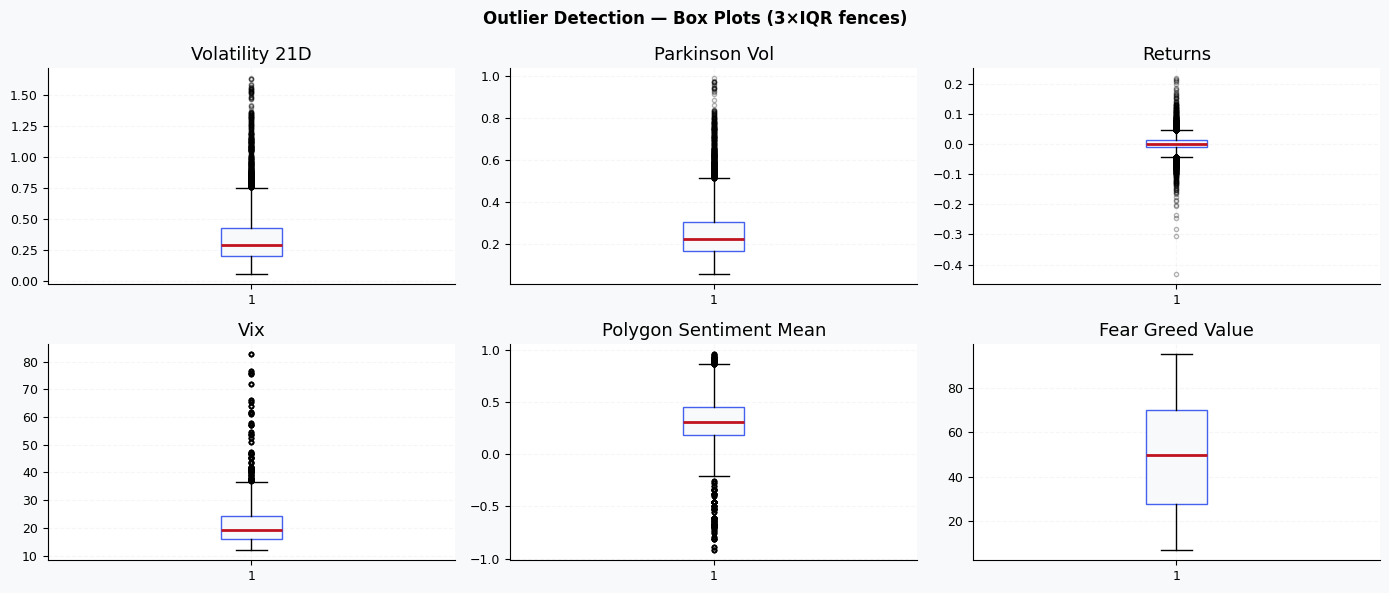


 Decision: ALL outliers KEPT — they represent real market crisis events


In [10]:
key_cols = ['volatility_21d','parkinson_vol','returns',
            'vix','polygon_sentiment_mean','fear_greed_value']
key_cols = [c for c in key_cols if c in df.columns]

rows = []
for col in key_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lo, hi = Q1 - 3*IQR, Q3 + 3*IQR
    n_out = ((df[col] < lo) | (df[col] > hi)).sum()
    rows.append({'Variable': col, 'Lower fence': round(lo,4),
                 'Upper fence': round(hi,4),
                 'Outliers N': n_out,
                 'Outliers %': round(n_out/len(df)*100, 2)})
display(pd.DataFrame(rows).set_index('Variable')
    .style.background_gradient(subset=['Outliers %'], cmap='YlOrRd')
    .set_caption('Outlier Summary — 3×IQR method'))


fig, axes = plt.subplots(2, 3, figsize=(14, 6))
fig.suptitle('Outlier Detection — Box Plots (3×IQR fences)', fontweight='bold')
for i, col in enumerate(key_cols):
    ax = axes[i//3][i%3]
    ax.boxplot(df[col].dropna(), patch_artist=True,
               boxprops=dict(facecolor=PALETTE['bg'], color=PALETTE['blue']),
               medianprops=dict(color=PALETTE['negative'], lw=2),
               flierprops=dict(marker='o', color=PALETTE['accent'], alpha=0.3, ms=3))
    ax.set_title(col.replace('_',' ').title()); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('fig_outliers.png', dpi=150, bbox_inches='tight')
plt.show()
print('\n Decision: ALL outliers KEPT — they represent real market crisis events')

In [11]:

spy = df[df['ticker']=='SPY'].copy().sort_values('date').reset_index(drop=True)


print('='*55)
print('   DATA CLEANING COMPLETE')
print('='*55)
print(f'  Full panel     : {df.shape[0]:,} rows × {df.shape[1]} cols')
print(f'  Tickers        : {df["ticker"].nunique()}')
print(f'  Date range     : {df["date"].min().date()} → {df["date"].max().date()}')
print(f'  SPY rows       : {len(spy)}')
print(f'  Primary sentiment: polygon_sentiment_mean ({df["polygon_sentiment_mean"].nunique()} unique values)')
print('='*55)

   DATA CLEANING COMPLETE
  Full panel     : 22,305 rows × 33 cols
  Tickers        : 15
  Date range     : 2020-02-03 → 2025-12-31
  SPY rows       : 1487
  Primary sentiment: polygon_sentiment_mean (1155 unique values)


---
# Section 2 — Visualizing Features

Three types of visualizations:
- **Distribution plots** — histograms & box plots
- **Time series plots** — temporal dynamics
- **Relationship plots** — scatter plots & correlation heatmap

## 2.1 Distribution Plots

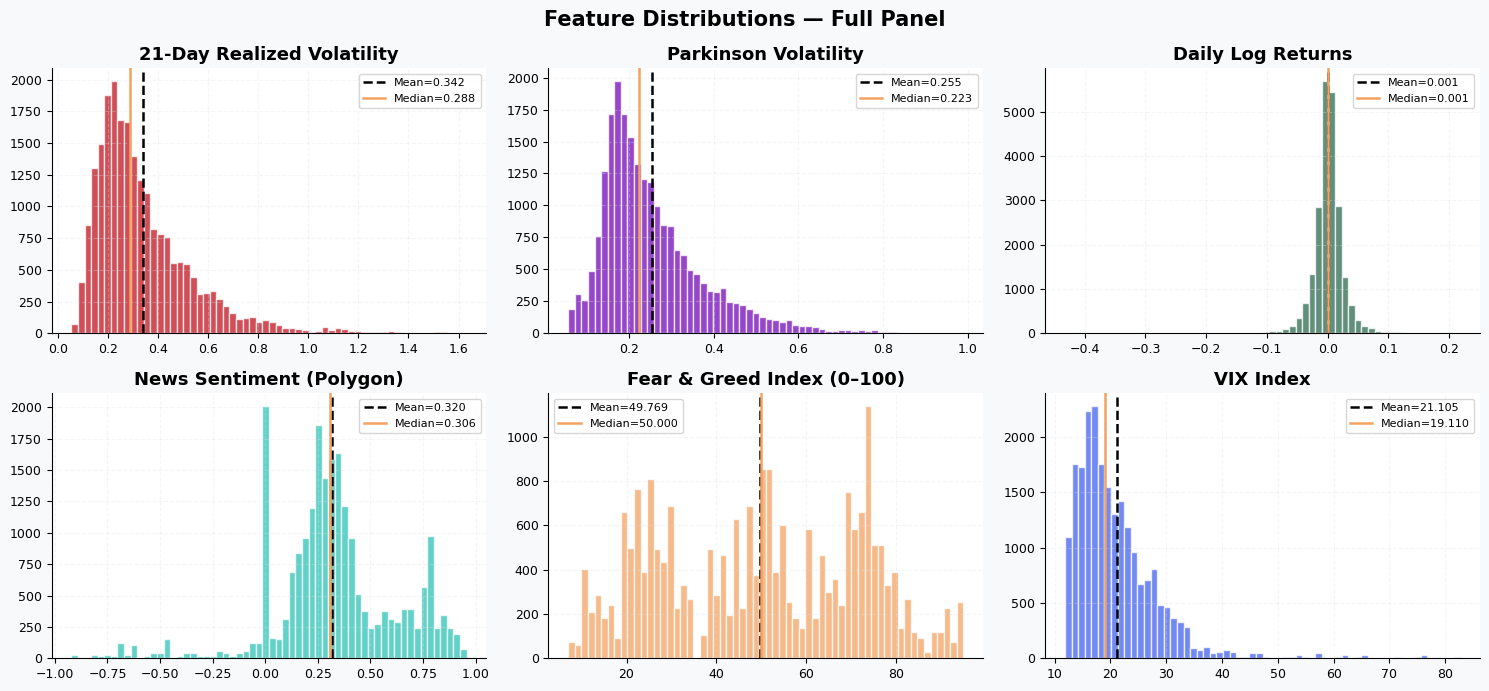

In [12]:
plot_vars = [
    ('volatility_21d',       '21-Day Realized Volatility', PALETTE['negative']),
    ('parkinson_vol',        'Parkinson Volatility',        PALETTE['purple']),
    ('returns',              'Daily Log Returns',           PALETTE['positive']),
    ('polygon_sentiment_mean','News Sentiment (Polygon)',   PALETTE['teal']),
    ('fear_greed_value',     'Fear & Greed Index (0–100)',  PALETTE['accent']),
    ('vix',                  'VIX Index',                   PALETTE['blue']),
]
plot_vars = [(c,l,clr) for c,l,clr in plot_vars if c in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
fig.suptitle('Feature Distributions — Full Panel', fontsize=15, fontweight='bold')
axes = axes.flatten()

for i, (col, label, color) in enumerate(plot_vars):
    data = df[col].dropna()
    axes[i].hist(data, bins=60, color=color, alpha=0.75, edgecolor='white', lw=0.3)
    axes[i].axvline(data.mean(),   color='black',          ls='--', lw=1.8,
                    label=f'Mean={data.mean():.3f}')
    axes[i].axvline(data.median(), color=PALETTE['accent'], ls='-',  lw=1.8,
                    label=f'Median={data.median():.3f}')
    axes[i].set_title(label, fontweight='bold')
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

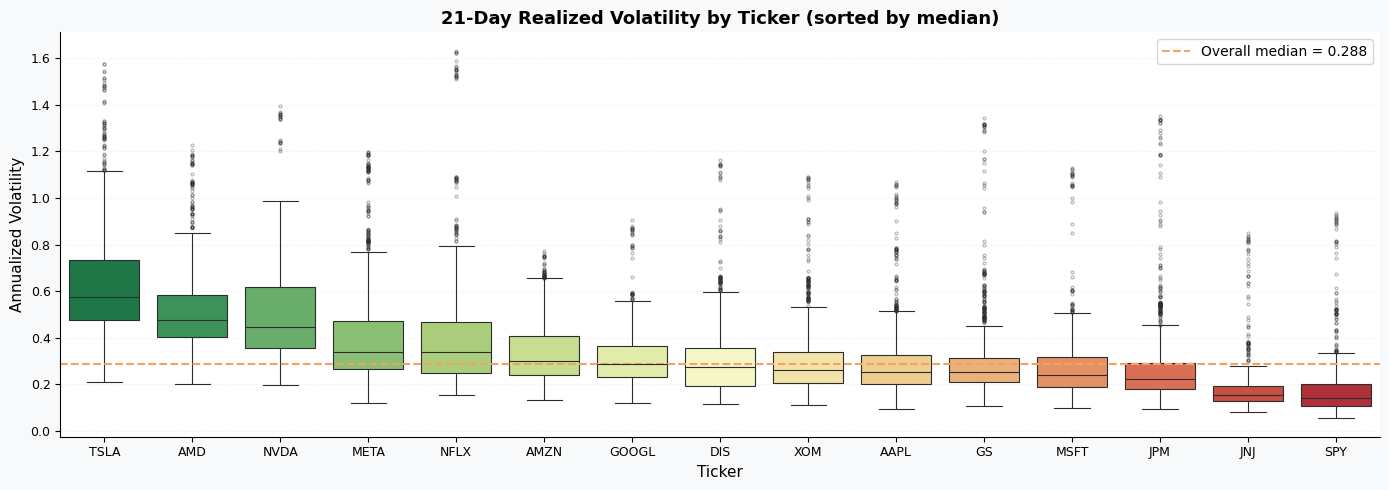

In [13]:
order = (df.groupby('ticker')['volatility_21d']
           .median().sort_values(ascending=False).index.tolist())

fig, ax = plt.subplots(figsize=(14, 5))
sns.boxplot(data=df, x='ticker', y='volatility_21d', order=order,
            palette='RdYlGn_r', linewidth=0.8,
            flierprops=dict(marker='o', ms=2, alpha=0.3), ax=ax)
ax.axhline(df['volatility_21d'].median(), color=PALETTE['accent'],
           ls='--', lw=1.5, label=f'Overall median = {df["volatility_21d"].median():.3f}')
ax.set_title('21-Day Realized Volatility by Ticker (sorted by median)', fontweight='bold')
ax.set_xlabel('Ticker'); ax.set_ylabel('Annualized Volatility')
ax.legend(); ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('fig_vol_by_ticker.png', dpi=150, bbox_inches='tight')
plt.show()

## 2.2 Time Series Plots

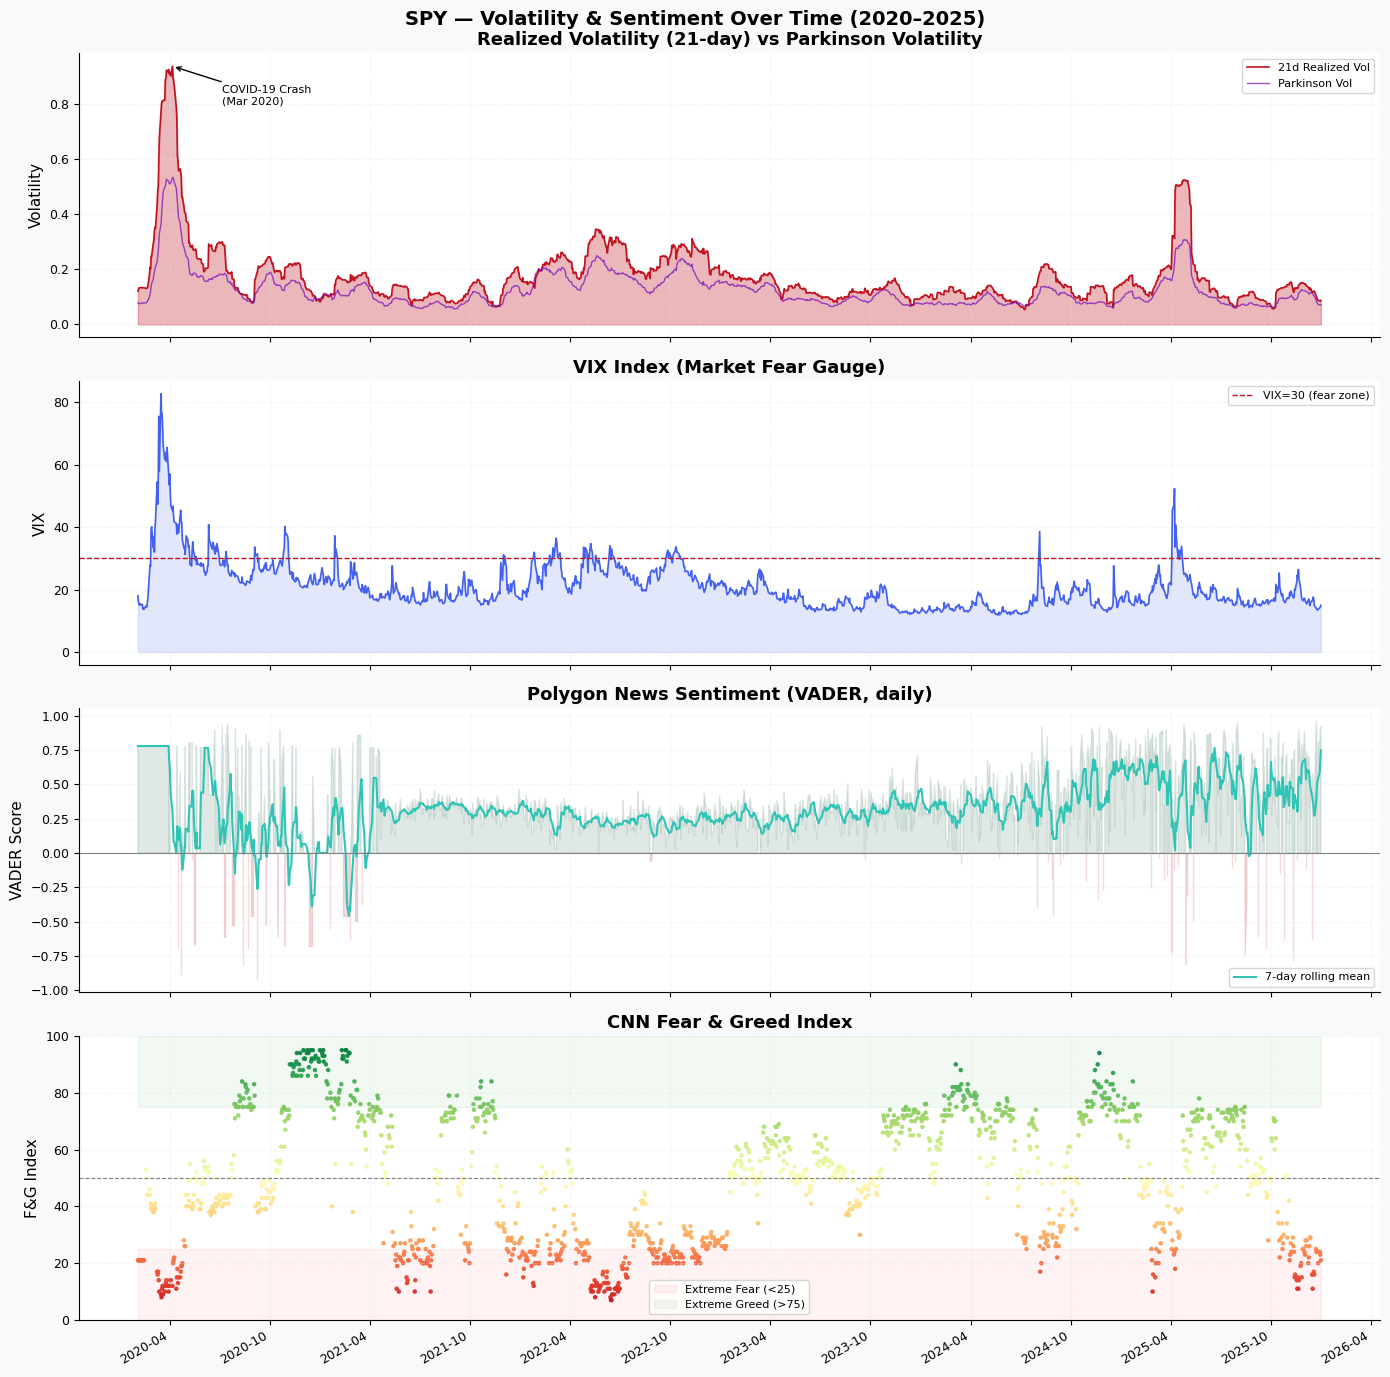

In [14]:
fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
fig.suptitle('SPY — Volatility & Sentiment Over Time (2020–2025)',
             fontsize=14, fontweight='bold')
ax = axes[0]
ax.fill_between(spy['date'], spy['volatility_21d'],
                alpha=0.3, color=PALETTE['negative'])
ax.plot(spy['date'], spy['volatility_21d'], color=PALETTE['negative'],
        lw=1.2, label='21d Realized Vol')
ax.plot(spy['date'], spy['parkinson_vol'], color=PALETTE['purple'],
        lw=1, alpha=0.7, label='Parkinson Vol')
idx_max = spy['volatility_21d'].idxmax()
ax.annotate('COVID-19 Crash\n(Mar 2020)',
            xy=(spy.loc[idx_max,'date'], spy.loc[idx_max,'volatility_21d']),
            xytext=(spy.loc[idx_max,'date'] + pd.Timedelta('90D'),
                    spy.loc[idx_max,'volatility_21d'] * 0.85),
            arrowprops=dict(arrowstyle='->', color='black'), fontsize=8)
ax.set_ylabel('Volatility'); ax.legend(fontsize=8)
ax.set_title('Realized Volatility (21-day) vs Parkinson Volatility', fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(spy['date'], spy['vix'], color=PALETTE['blue'], lw=1.2)
ax.fill_between(spy['date'], spy['vix'], alpha=0.15, color=PALETTE['blue'])
ax.axhline(30, color=PALETTE['negative'], lw=1, ls='--', label='VIX=30 (fear zone)')
ax.set_ylabel('VIX'); ax.legend(fontsize=8)
ax.set_title('VIX Index (Market Fear Gauge)', fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[2]
pol = spy[['date','polygon_sentiment_mean']].dropna()
roll = pol['polygon_sentiment_mean'].rolling(7, min_periods=1).mean()
ax.plot(pol['date'], roll, color=PALETTE['teal'], lw=1.5, label='7-day rolling mean')
ax.fill_between(pol['date'], 0, pol['polygon_sentiment_mean'],
                where=(pol['polygon_sentiment_mean']>=0), alpha=0.15, color=PALETTE['positive'])
ax.fill_between(pol['date'], 0, pol['polygon_sentiment_mean'],
                where=(pol['polygon_sentiment_mean']<0), alpha=0.15, color=PALETTE['negative'])
ax.axhline(0, color='grey', lw=0.8)
ax.set_ylabel('VADER Score')
ax.set_title('Polygon News Sentiment (VADER, daily)', fontweight='bold')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

ax = axes[3]
fg = spy[['date','fear_greed_value']].dropna()
sc = ax.scatter(fg['date'], fg['fear_greed_value'], c=fg['fear_greed_value'],
                cmap='RdYlGn', s=5, alpha=0.9, vmin=0, vmax=100)
ax.axhline(50, color='grey', lw=0.8, ls='--')
ax.fill_between(fg['date'], 0, 25, alpha=0.05, color='red', label='Extreme Fear (<25)')
ax.fill_between(fg['date'], 75, 100, alpha=0.05, color='green', label='Extreme Greed (>75)')
ax.set_ylabel('F&G Index'); ax.set_ylim(0, 100)
ax.set_title('CNN Fear & Greed Index', fontweight='bold')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.savefig('fig_time_series.png', dpi=150, bbox_inches='tight')
plt.show()

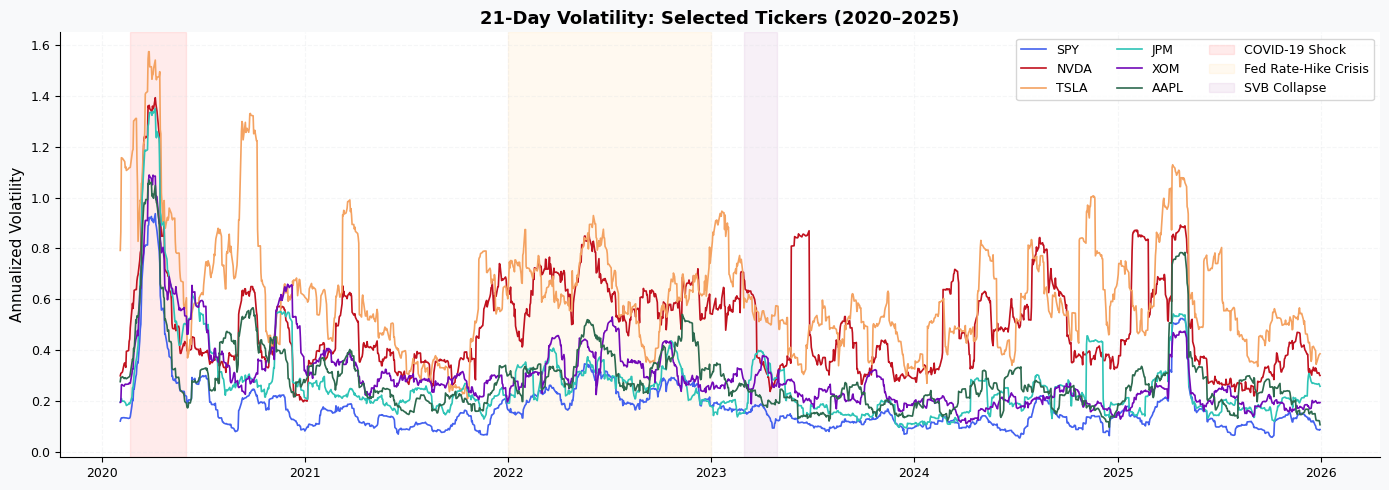

In [15]:
selected  = ['SPY','NVDA','TSLA','JPM','XOM','AAPL']
clr_map   = [PALETTE['blue'], PALETTE['negative'], PALETTE['accent'],
             PALETTE['teal'], PALETTE['purple'], PALETTE['positive']]

fig, ax = plt.subplots(figsize=(14, 5))
for ticker, color in zip(selected, clr_map):
    sub = df[df['ticker']==ticker].sort_values('date')
    ax.plot(sub['date'], sub['volatility_21d'], lw=1.2, color=color, label=ticker)

# Crisis periods are shaded
ax.axvspan(pd.Timestamp('2020-02-20'), pd.Timestamp('2020-06-01'),
           alpha=0.08, color='red', label='COVID-19 Shock')
ax.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'),
           alpha=0.06, color='orange', label='Fed Rate-Hike Crisis')
ax.axvspan(pd.Timestamp('2023-03-01'), pd.Timestamp('2023-04-30'),
           alpha=0.06, color='purple', label='SVB Collapse')

ax.set_title('21-Day Volatility: Selected Tickers (2020–2025)', fontweight='bold')
ax.set_ylabel('Annualized Volatility')
ax.legend(fontsize=9, ncol=3); ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.savefig('fig_vol_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 2.3 Relationship Plots

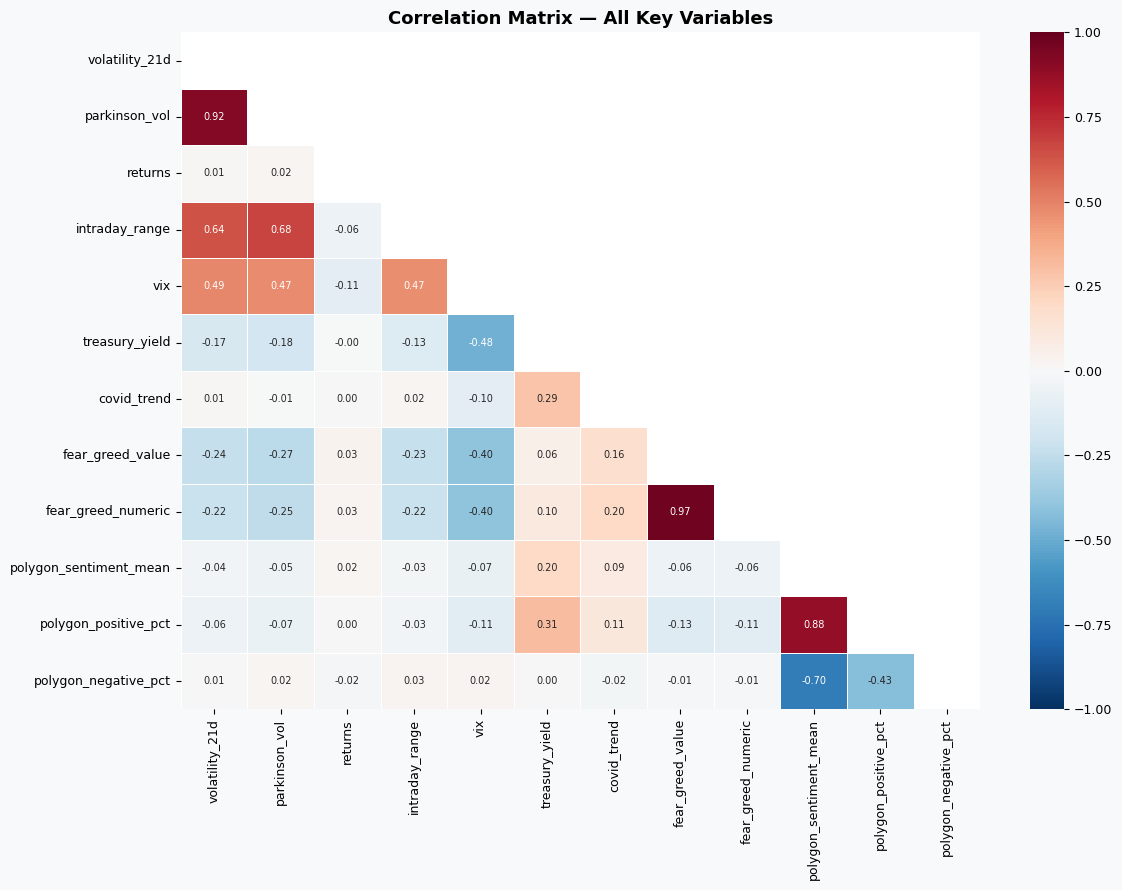

In [17]:
corr_cols = [
    'volatility_21d','parkinson_vol','returns','intraday_range',
    'vix','treasury_yield','covid_trend',
    'fear_greed_value','fear_greed_numeric',
    'polygon_sentiment_mean','polygon_positive_pct','polygon_negative_pct',
]
corr_cols = [c for c in corr_cols if c in df.columns]

corr_mat = df[corr_cols].corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            linewidths=0.5, annot_kws={'size': 7}, ax=ax)
ax.set_title('Correlation Matrix — All Key Variables',
             fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('fig_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

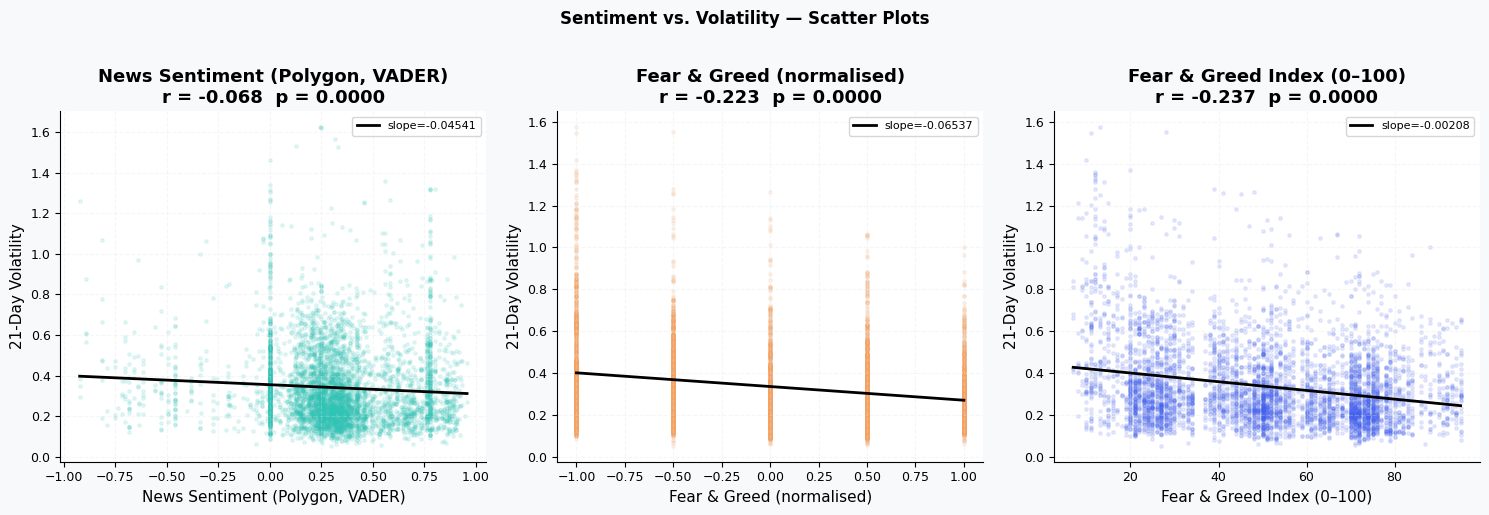

In [18]:
sent_vars = [
    ('polygon_sentiment_mean','News Sentiment (Polygon, VADER)', PALETTE['teal']),
    ('fear_greed_numeric',    'Fear & Greed (normalised)',        PALETTE['accent']),
    ('fear_greed_value',      'Fear & Greed Index (0–100)',       PALETTE['blue']),
]
sent_vars = [(c,l,clr) for c,l,clr in sent_vars if c in df.columns]

fig, axes = plt.subplots(1, len(sent_vars), figsize=(5*len(sent_vars), 5))
if len(sent_vars)==1: axes=[axes]

for ax, (col, label, color) in zip(axes, sent_vars):
    samp = df[['volatility_21d', col]].dropna().sample(
        min(5000, len(df)), random_state=42)
    ax.scatter(samp[col], samp['volatility_21d'],
               alpha=0.12, s=6, color=color)
    z = np.polyfit(samp[col], samp['volatility_21d'], 1)
    xs = np.linspace(samp[col].min(), samp[col].max(), 100)
    ax.plot(xs, np.poly1d(z)(xs), color='black', lw=2, label=f'slope={z[0]:.5f}')
    r, pval = stats.pearsonr(samp[col], samp['volatility_21d'])
    ax.set_title(f'{label}\nr = {r:.3f}  p = {pval:.4f}', fontweight='bold')
    ax.set_xlabel(label); ax.set_ylabel('21-Day Volatility')
    ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

plt.suptitle('Sentiment vs. Volatility — Scatter Plots',
             fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Section 3 — Statistical Summaries

Following Kuuluvainen (2014) and Abdollahi et al. (2024), I compute:
- Descriptive statistics (mean, std, quartiles)
- Group statistics by ticker
- Correlation table with significance levels
- **CAPM analysis** — abnormal returns (following Dam 2023)

In [19]:
desc_cols = ['volatility_21d','parkinson_vol','returns',
             'vix','fear_greed_value',
             'polygon_sentiment_mean','polygon_positive_pct','polygon_negative_pct']
desc_cols = [c for c in desc_cols if c in df.columns]

desc = df[desc_cols].describe().T
desc.insert(0, 'N', df[desc_cols].count())
desc.rename(columns={'mean':'Mean','std':'Std','min':'Min',
                     '25%':'Q1','50%':'Median','75%':'Q3','max':'Max'}, inplace=True)
desc.index = ['21d Realized Volatility','Parkinson Volatility','Log Returns',
              'VIX','Fear & Greed Index',
              'News Sentiment (VADER)','Positive News %','Negative News %'
             ][:len(desc_cols)]

print('Table 1. Descriptive Statistics — Key Variables')
display(desc.round(4).style
    .background_gradient(subset=['Std'], cmap='Blues')
    .format(precision=4)
    .set_caption('Full panel, N = daily observations per ticker'))

Table 1. Descriptive Statistics — Key Variables


,N,count,Mean,Std,Min,Q1,Median,Q3,Max
21d Realized Volatility,22305,22305.0000,0.3418,0.2004,0.0540,0.2059,0.2880,0.4248,1.6324
Parkinson Volatility,22305,22305.0000,0.2546,0.1225,0.0566,0.1703,0.2230,0.3076,0.9897
Log Returns,22305,22305.0000,0.0008,0.0249,-0.4326,-0.0099,0.0009,0.0119,0.2181
VIX,22305,22305.0000,21.1054,7.9068,11.8600,16.0300,19.1100,24.2300,82.6900
Fear & Greed Index,22295,22295.0000,49.7688,22.2430,7.0000,28.0000,50.0000,70.0000,95.0000
News Sentiment (VADER),22305,22305.0000,0.3197,0.2952,-0.9217,0.1847,0.3059,0.4550,0.9578
Positive News %,22305,22305.0000,0.6051,0.3067,0.0000,0.5000,0.6180,0.8000,1.0000
Negative News %,22305,22305.0000,0.1418,0.2003,0.0000,0.0000,0.1059,0.1951,1.0000


In [20]:
group_stats = df.groupby('ticker').agg(
    N           =('volatility_21d','count'),
    Mean_Vol    =('volatility_21d','mean'),
    Median_Vol  =('volatility_21d','median'),
    Max_Vol     =('volatility_21d','max'),
    Mean_Return =('returns','mean'),
    Std_Return  =('returns','std'),
    Sharpe      =('returns', lambda x: x.mean()/x.std()*np.sqrt(252))
).round(4).sort_values('Mean_Vol', ascending=False)

print('Table 2. Statistics by Ticker')
display(group_stats.style
    .background_gradient(subset=['Mean_Vol','Max_Vol'], cmap='YlOrRd')
    .background_gradient(subset=['Sharpe'], cmap='RdYlGn')
    .format(precision=4)
    .set_caption('Sorted by mean volatility (descending)'))

Table 2. Statistics by Ticker


,N,Mean_Vol,Median_Vol,Max_Vol,Mean_Return,Std_Return,Sharpe
ticker,,,,,,,
TSLA,1487,0.6218,0.5750,1.5742,0.0016,0.0418,0.5969
AMD,1487,0.5109,0.4782,1.2291,0.0010,0.0338,0.4788
NVDA,1487,0.4977,0.4475,1.3930,0.0023,0.0335,1.1019
META,1487,0.3984,0.3396,1.1985,0.0008,0.0279,0.4551
NFLX,1487,0.3965,0.3395,1.6324,0.0007,0.0284,0.3757
AMZN,1487,0.3364,0.3020,0.7725,0.0006,0.0225,0.3944
GOOGL,1487,0.3074,0.2859,0.9050,0.0010,0.0205,0.7700
DIS,1487,0.2987,0.2748,1.1613,-0.0001,0.0210,-0.0873
XOM,1487,0.2976,0.2630,1.0889,0.0006,0.0208,0.4833


In [21]:
x_cols = ['polygon_sentiment_mean','polygon_positive_pct','polygon_negative_pct',
          'fear_greed_value','fear_greed_numeric','vix','covid_trend']
x_cols = [c for c in x_cols if c in df.columns]
y_cols = ['volatility_21d','parkinson_vol']

rows = []
for xc in x_cols:
    row = {'Variable': xc.replace('_',' ').title()}
    for yc in y_cols:
        sub = df[[xc, yc]].dropna()
        r, p = stats.pearsonr(sub[xc], sub[yc])
        sig = '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else ''
        row[yc.replace('_',' ').title()] = f'{r:.3f}{sig}'
        row[f'N'] = len(sub)
    rows.append(row)

print('Table 3. Pearson Correlations with Volatility')
print('   * p<0.05  ** p<0.01  *** p<0.001')
display(pd.DataFrame(rows).set_index('Variable').style
    .set_caption('Correlation between sentiment/macro indicators and volatility measures'))

Table 3. Pearson Correlations with Volatility
   * p<0.05  ** p<0.01  *** p<0.001


,Volatility 21D,N,Parkinson Vol
Variable,,,
Polygon Sentiment Mean,-0.038***,22305,-0.052***
Polygon Positive Pct,-0.061***,22305,-0.070***
Polygon Negative Pct,0.007,22305,0.016*
Fear Greed Value,-0.239***,22295,-0.268***
Fear Greed Numeric,-0.224***,22295,-0.253***
Vix,0.488***,22305,0.473***
Covid Trend,0.011,22305,-0.005


## 3.4 CAPM Analysis — Abnormal Returns

Following **Dam (2023)** who used CAPM to measure abnormal returns around Elon Musk's tweets, we compute:

$$E(R_i) = r_f + \beta_i (R_M - r_f)$$

$$AR_i = R_i - E(R_i)$$

where $R_M$ = SPY daily return (market proxy), $r_f$ = 10-year Treasury / 252 (daily risk-free rate).

In [22]:
mkt = df[df['ticker']=='SPY'][['date','returns','treasury_yield']].copy()
mkt.columns = ['date','market_return','rf_annual']
mkt['rf_daily'] = mkt['rf_annual'] / 100 / 252  # annualized → daily
mkt['excess_mkt'] = mkt['market_return'] - mkt['rf_daily']

capm_results = []
df_with_ar   = []

for ticker in df['ticker'].cat.categories:
    if ticker == 'SPY':
        continue
    stock = df[df['ticker']==ticker][['date','returns']].copy()
    merged = stock.merge(mkt, on='date').dropna()
    if len(merged) < 50:
        continue

    merged['excess_stock'] = merged['returns'] - merged['rf_daily']
    X = sm.add_constant(merged['excess_mkt'])
    model = sm.OLS(merged['excess_stock'], X).fit()
    alpha = model.params['const']
    beta  = model.params['excess_mkt']

    merged['expected_return'] = merged['rf_daily'] + beta * merged['excess_mkt']
    merged['abnormal_return'] = merged['returns'] - merged['expected_return']
    merged['ticker'] = ticker
    df_with_ar.append(merged)

    capm_results.append({
        'Ticker': ticker,
        'Beta (β)': round(beta, 4),
        'Alpha (α)': round(alpha, 6),
        'R²': round(model.rsquared, 4),
        'Mean AR': round(merged['abnormal_return'].mean(), 6),
        'Std AR': round(merged['abnormal_return'].std(), 4),
        'N': len(merged)
    })

capm_df   = pd.DataFrame(capm_results).set_index('Ticker').sort_values('Beta (β)', ascending=False)
ar_panel  = pd.concat(df_with_ar, ignore_index=True)

print('Table 4. CAPM Results — Beta, Alpha, Abnormal Returns')
print('   R_i = rf + β(R_M − rf) + ε    |    AR = actual − expected')
display(capm_df.style
    .background_gradient(subset=['Beta (β)'], cmap='RdYlGn_r')
    .background_gradient(subset=['R²'], cmap='Blues')
    .format(precision=4)
    .set_caption('β>1 = more volatile than market; α>0 = excess return after risk-adjustment'))

Table 4. CAPM Results — Beta, Alpha, Abnormal Returns
   R_i = rf + β(R_M − rf) + ε    |    AR = actual − expected


,Beta (β),Alpha (α),R²,Mean AR,Std AR,N
Ticker,,,,,,
NVDA,1.7925,0.0014,0.4963,0.0014,0.0238,1487
TSLA,1.7156,0.0007,0.2913,0.0007,0.0352,1487
AMD,1.6463,0.0002,0.4105,0.0002,0.0260,1487
META,1.3367,0.0001,0.3962,0.0001,0.0217,1487
AAPL,1.1943,0.0002,0.6158,0.0002,0.0124,1487
GS,1.1818,0.0003,0.5642,0.0003,0.0137,1487
AMZN,1.1422,-0.0001,0.4454,-0.0001,0.0168,1487
MSFT,1.1412,0.0001,0.6468,0.0001,0.0111,1487
GOOGL,1.1338,0.0004,0.5272,0.0004,0.0141,1487


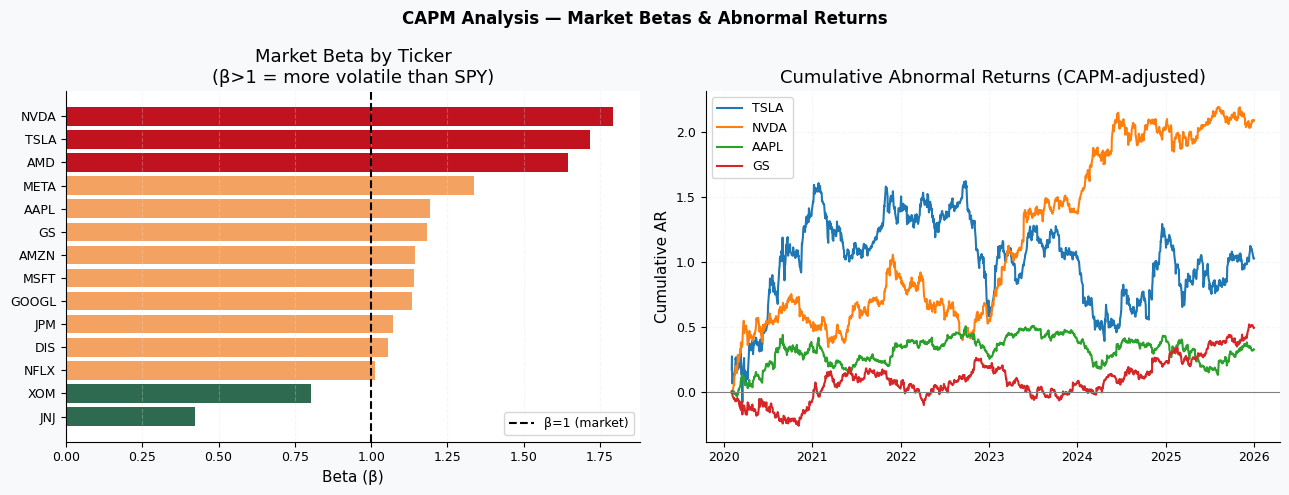

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('CAPM Analysis — Market Betas & Abnormal Returns',
             fontweight='bold')
ax = axes[0]
betas = capm_df['Beta (β)'].sort_values(ascending=True)
colors_b = [PALETTE['negative'] if b > 1.5 else
             PALETTE['accent']   if b > 1.0 else
             PALETTE['positive'] for b in betas]
bars = ax.barh(betas.index, betas.values, color=colors_b)
ax.axvline(1, color='black', ls='--', lw=1.5, label='β=1 (market)')
ax.set_xlabel('Beta (β)')
ax.set_title('Market Beta by Ticker\n(β>1 = more volatile than SPY)')
ax.legend(fontsize=9); ax.grid(True, axis='x', alpha=0.3)

ax = axes[1]
for ticker in ['TSLA','NVDA','AAPL','GS']:
    sub = ar_panel[ar_panel['ticker']==ticker].sort_values('date')
    if not sub.empty:
        cum_ar = sub['abnormal_return'].cumsum()
        ax.plot(sub['date'], cum_ar, lw=1.5, label=ticker)
ax.axhline(0, color='grey', lw=0.8)
ax.set_title('Cumulative Abnormal Returns (CAPM-adjusted)')
ax.set_ylabel('Cumulative AR'); ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig('fig_capm.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Section 4 — H1: Asymmetric Impact of Negative vs. Positive Sentiment on Parkinson Volatility

**H₀:** Negative and positive news sentiment have an equal impact on next-day Parkinson volatility  
**H₁:** Negative news sentiment has a **significantly stronger positive impact** on next-day Parkinson volatility than positive sentiment — days with low/negative sentiment are followed by higher volatility than days with high/positive sentiment

**Reasoning:** Directly addresses the core of the research question: does negative sentiment dominate?  
Following Kuuluvainen (2014), who found that negative news (NNI) increases next-day volatility by +0.56% while positive news (NPI) reduces it by −0.60%. Abdollahi et al. (2024) use Parkinson volatility as the target measure — we adopt the same.

$$\text{ParkVol}_{t+1} = \alpha + \beta_1 \cdot \text{NegSent}_t + \beta_2 \cdot \text{PosSent}_t + \gamma \cdot \text{VIX}_t + \delta \cdot \text{COVID}_t + \varepsilon$$


In [24]:
h1 = spy.copy()
h1['polygon_sentiment_mean'] = h1['polygon_sentiment_mean'].ffill()
h1['fear_greed_numeric']     = h1['fear_greed_numeric'].ffill()
h1 = h1.sort_values('date')
h1['vol_next'] = h1['parkinson_vol'].shift(-1)
q25 = h1['polygon_sentiment_mean'].quantile(0.25)
q75 = h1['polygon_sentiment_mean'].quantile(0.75)

h1['sent_group'] = pd.cut(
    h1['polygon_sentiment_mean'],
    bins=[-np.inf, q25, q75, np.inf],
    labels=['Negative (low)', 'Neutral', 'Positive (high)']
)

h1 = h1.dropna(subset=['vol_next', 'polygon_sentiment_mean', 'vix'])

print(f'Q25 ("negative" threshold) : {q25:.4f}')
print(f'Q75 ("positive" threshold) : {q75:.4f}')
print('\nGroup sizes:')
print(h1['sent_group'].value_counts().to_string())


Q25 ("negative" threshold) : 0.1850
Q75 ("positive" threshold) : 0.4545

Group sizes:
sent_group
Neutral            743
Negative (low)     372
Positive (high)    371


In [25]:
neg_vol = h1[h1['sent_group'] == 'Negative (low)']['vol_next'].dropna()
pos_vol = h1[h1['sent_group'] == 'Positive (high)']['vol_next'].dropna()
neu_vol = h1[h1['sent_group'] == 'Neutral']['vol_next'].dropna()
t_stat, p_ttest = ttest_ind(neg_vol, pos_vol, equal_var=False, alternative='greater')

u_stat, p_mw = mannwhitneyu(neg_vol, pos_vol, alternative='greater')

pooled_std = np.sqrt((neg_vol.std()**2 + pos_vol.std()**2) / 2)
cohens_d   = (neg_vol.mean() - pos_vol.mean()) / pooled_std

print('='*62)
print('  H1: Asymmetric Impact — Parkinson Volatility (next-day)')
print('='*62)
print(f'  Negative days  N={len(neg_vol):>4}   mean Parkinson vol = {neg_vol.mean():.5f}')
print(f'  Neutral  days  N={len(neu_vol):>4}   mean Parkinson vol = {neu_vol.mean():.5f}')
print(f'  Positive days  N={len(pos_vol):>4}   mean Parkinson vol = {pos_vol.mean():.5f}')
print(f'\n  Difference (neg − pos): {neg_vol.mean()-pos_vol.mean():.5f}')
print(f'  Cohen\'s d (effect size): {cohens_d:.4f}')
print(f'\n  Welch t-test (one-sided, neg > pos):')
print(f'    t = {t_stat:.4f}   p = {p_ttest:.4f}')
print(f'    → {"REJECT H₀ " if p_ttest < 0.05 else "Fail to reject H₀ "}')
print(f'\n  Mann-Whitney U (non-parametric):')
print(f'    U = {u_stat:.0f}   p = {p_mw:.4f}')
print(f'    → {"REJECT H₀ " if p_mw < 0.05 else "Fail to reject H₀ "}')
print('='*62)

h1_reject = p_ttest < 0.05


  H1: Asymmetric Impact — Parkinson Volatility (next-day)
  Negative days  N= 372   mean Parkinson vol = 0.14074
  Neutral  days  N= 743   mean Parkinson vol = 0.11537
  Positive days  N= 371   mean Parkinson vol = 0.12783

  Difference (neg − pos): 0.01291
  Cohen's d (effect size): 0.1572

  Welch t-test (one-sided, neg > pos):
    t = 2.1425   p = 0.0162
    → REJECT H₀ 

  Mann-Whitney U (non-parametric):
    U = 86406   p = 0.0000
    → REJECT H₀ 


In [26]:

med = h1['polygon_sentiment_mean'].median()
h1['sent_neg'] = h1['polygon_sentiment_mean'].clip(upper=med).abs()
h1['sent_pos'] = h1['polygon_sentiment_mean'].clip(lower=med)

model_h1 = smf.ols(
    'vol_next ~ sent_neg + sent_pos + vix + covid_trend',
    data=h1.dropna()
).fit(cov_type='HC3')

print('OLS: ParkVol(t+1) ~ NegSent + PosSent + VIX + COVID')
print(f'   R² = {model_h1.rsquared:.4f}   Adj-R² = {model_h1.rsquared_adj:.4f}')
print(model_h1.summary().tables[1])
print('\n  Interpretation: β(NegSent) > β(PosSent) supports H₁')


OLS: ParkVol(t+1) ~ NegSent + PosSent + VIX + COVID
   R² = 0.6000   Adj-R² = 0.5989
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0359      0.009     -4.142      0.000      -0.053      -0.019
sent_neg        0.0079      0.011      0.713      0.476      -0.014       0.030
sent_pos       -0.0033      0.006     -0.532      0.595      -0.015       0.009
vix             0.0071      0.000     23.214      0.000       0.007       0.008
covid_trend     0.0003   5.95e-05      4.313      0.000       0.000       0.000

  Interpretation: β(NegSent) > β(PosSent) supports H₁


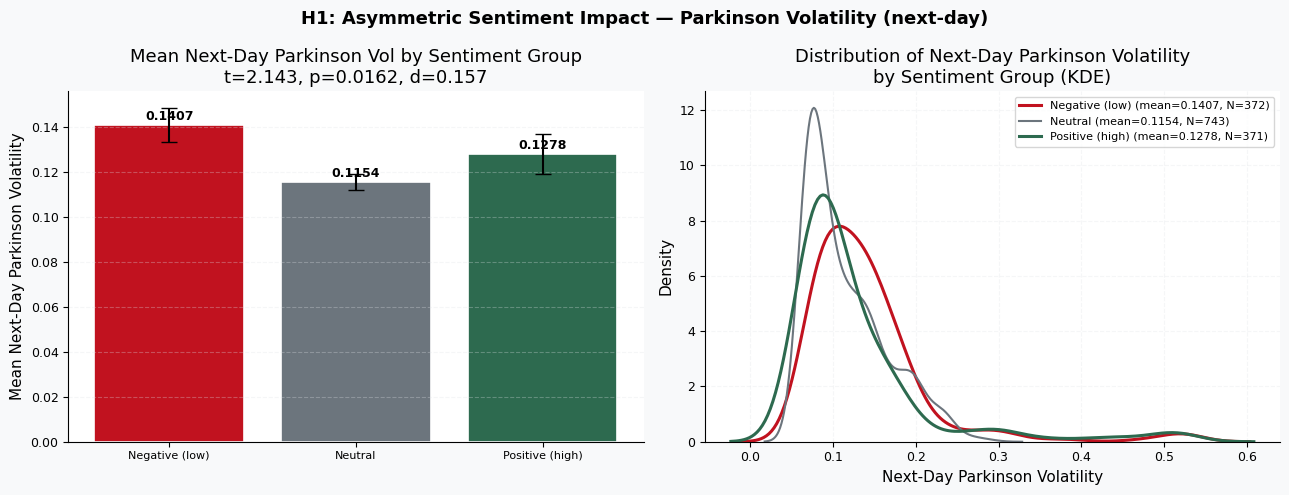

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('H1: Asymmetric Sentiment Impact — Parkinson Volatility (next-day)',
             fontweight='bold', fontsize=13)
ax = axes[0]
groups_ordered = ['Negative (low)', 'Neutral', 'Positive (high)']
means = h1.groupby('sent_group')['vol_next'].mean().reindex(groups_ordered)
sems  = h1.groupby('sent_group')['vol_next'].sem().reindex(groups_ordered) * 1.96
bar_colors = [PALETTE['negative'], PALETTE['neutral'], PALETTE['positive']]

bars = ax.bar(means.index, means.values, yerr=sems.values,
              capsize=6, color=bar_colors, edgecolor='white', lw=1.2)
for bar, val in zip(bars, means.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Mean Next-Day Parkinson Volatility')
ax.set_title(f'Mean Next-Day Parkinson Vol by Sentiment Group\n'
             f't={t_stat:.3f}, p={p_ttest:.4f}, d={cohens_d:.3f}')
ax.tick_params(axis='x', labelsize=8)
ax.grid(True, axis='y', alpha=0.3)

ax = axes[1]
for grp, color, lw_v in [
    ('Negative (low)',  PALETTE['negative'], 2.2),
    ('Neutral',         PALETTE['neutral'],  1.5),
    ('Positive (high)', PALETTE['positive'], 2.2),
]:
    data = h1[h1['sent_group'] == grp]['vol_next'].dropna()
    if len(data) > 5:
        sns.kdeplot(data, ax=ax, color=color, lw=lw_v,
                    label=f'{grp} (mean={data.mean():.4f}, N={len(data)})')

ax.set_xlabel('Next-Day Parkinson Volatility')
ax.set_ylabel('Density')
ax.set_title('Distribution of Next-Day Parkinson Volatility\nby Sentiment Group (KDE)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig_h1_asymmetry.png', dpi=150, bbox_inches='tight')
plt.show()


---
# Section 5 — H2: Asymmetric Effect Is Amplified During High-Uncertainty Periods

**H₀:** The negative sentiment effect on Parkinson volatility is the same across all market conditions  
**H₁:** The negative sentiment effect on Parkinson volatility is **significantly stronger** during high-uncertainty periods (high VIX / crisis) than during calm periods

**Reasoning:** The research question explicitly asks about *"periods of increased uncertainty"*. Kuuluvainen (2014) found 30–40% stronger effects in bear markets. Costola et al. (2021) document that the COVID lockdown announcement produced the largest single-day market impact. Ehsan et al. (2025) show negative sentiment dominates especially in crisis periods.

**Method:**
1. Split the sample into High-VIX (stress) and Low-VIX (calm) regimes using VIX median
2. Compare the sentiment–volatility slope across regimes (regime-split correlations + OLS)
3. Interaction model: `ParkVol(t+1) ~ Sent + Regime + Sent×Regime + VIX + COVID`
   — a significant interaction coefficient β₃ confirms crisis amplification


In [28]:
h2 = h1.copy()
h2 = h2.dropna(subset=['vix', 'polygon_sentiment_mean', 'vol_next'])
vix_med = h2['vix'].median()
h2['regime']       = np.where(h2['vix'] > vix_med, 'High VIX (Stress)', 'Low VIX (Calm)')
h2['regime_dummy'] = (h2['regime'] == 'High VIX (Stress)').astype(int)

print(f'📌 VIX median split: {vix_med:.2f}')
print(h2['regime'].value_counts().to_string())
print(f'\n  Mean Parkinson vol — Stress: {h2[h2["regime"]=="High VIX (Stress)"]["vol_next"].mean():.5f}')
print(f'  Mean Parkinson vol — Calm  : {h2[h2["regime"]=="Low VIX (Calm)"]["vol_next"].mean():.5f}')

CRISES = [
    ('COVID-19 Crash',     '2020-02-20', '2020-06-01'),
    ('Fed Rate Hikes',     '2022-01-01', '2022-12-31'),
    ('SVB Collapse',       '2023-03-01', '2023-04-30'),
]


📌 VIX median split: 19.12
regime
Low VIX (Calm)       743
High VIX (Stress)    743

  Mean Parkinson vol — Stress: 0.16214
  Mean Parkinson vol — Calm  : 0.08753


In [29]:
print('Sentiment → Next-day Parkinson Volatility by Regime:\n')
regime_corrs = {}
for regime, grp in h2.groupby('regime'):
    sub = grp[['polygon_sentiment_mean', 'vol_next']].dropna()
    r, p = stats.pearsonr(sub['polygon_sentiment_mean'], sub['vol_next'])
    if sub['polygon_sentiment_mean'].std() > 1e-8:
        slope, *_ = stats.linregress(sub['polygon_sentiment_mean'], sub['vol_next'])
    else:
        slope = np.nan
    regime_corrs[regime] = {'r': r, 'slope': slope, 'p': p, 'N': len(sub)}
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'n.s.'
    print(f'  {regime:<25}  r={r:+.4f} {sig}  slope={slope:+.6f}  N={len(sub)}')

stress_r = regime_corrs['High VIX (Stress)']['r']
calm_r   = regime_corrs['Low VIX (Calm)']['r']
print(f'\n  Amplification ratio (|r_stress| / |r_calm|): {abs(stress_r)/max(abs(calm_r),1e-8):.2f}x')

# Interaction OLS: ParkVol ~ Sent + Regime + Sent×Regime + VIX + COVID
h2['sent_x_regime'] = h2['polygon_sentiment_mean'] * h2['regime_dummy']

model_h2 = smf.ols(
    'vol_next ~ polygon_sentiment_mean + regime_dummy + sent_x_regime + vix + covid_trend',
    data=h2.dropna()
).fit(cov_type='HC3')

h2_interaction_p = model_h2.pvalues.get('sent_x_regime', 1.0)
h2_reject        = h2_interaction_p < 0.05

print('\n Interaction OLS: ParkVol(t+1) ~ Sent + Regime + Sent×Regime + VIX + COVID')
print(f'   R² = {model_h2.rsquared:.4f}   Adj-R² = {model_h2.rsquared_adj:.4f}')
print(model_h2.summary().tables[1])
print(f'\n  Interaction p-value = {h2_interaction_p:.4f}')
print(f'  → {"REJECT H₀ — stronger effect in stress periods" if h2_reject else "Fail to reject H₀ "}')


Sentiment → Next-day Parkinson Volatility by Regime:

  High VIX (Stress)          r=+0.0991 **  slope=+0.023597  N=743
  Low VIX (Calm)             r=-0.0265 n.s.  slope=-0.002302  N=743

  Amplification ratio (|r_stress| / |r_calm|): 3.73x

 Interaction OLS: ParkVol(t+1) ~ Sent + Regime + Sent×Regime + VIX + COVID
   R² = 0.6018   Adj-R² = 0.6004
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0316      0.010     -3.307      0.001      -0.050      -0.013
polygon_sentiment_mean    -0.0019      0.003     -0.602      0.547      -0.008       0.004
regime_dummy               0.0007      0.005      0.145      0.884      -0.008       0.010
sent_x_regime              0.0112      0.007      1.579      0.114      -0.003       0.025
vix                        0.0069      0.000     13.899      0.000       0.006       0.008
covid_trend 

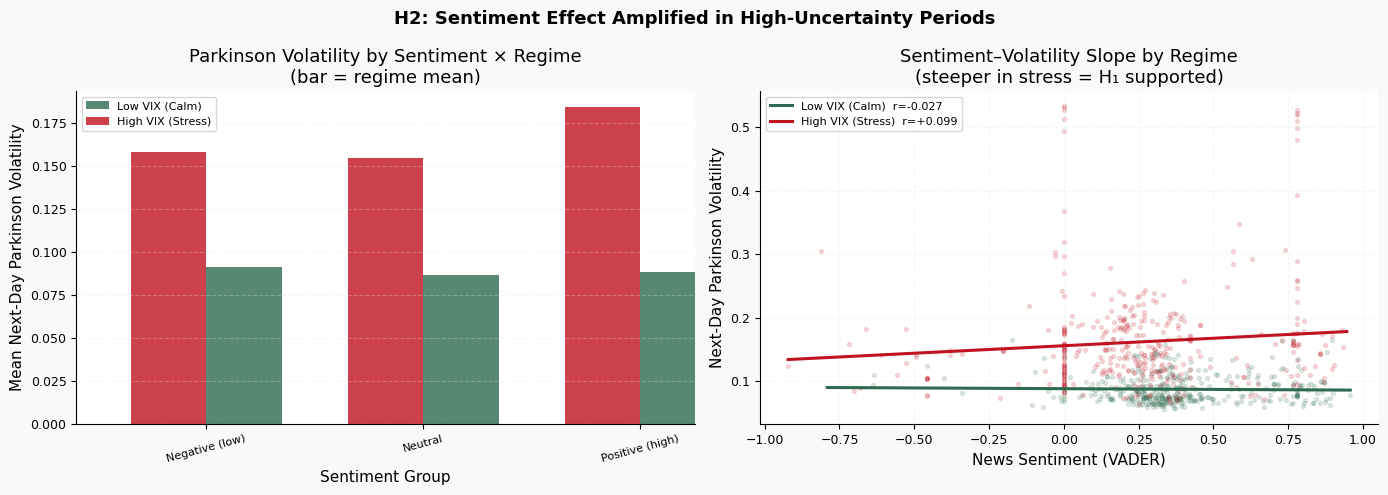

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('H2: Sentiment Effect Amplified in High-Uncertainty Periods',
             fontweight='bold', fontsize=13)
ax = axes[0]
plot_data = h2.dropna(subset=['sent_group', 'regime', 'vol_next'])
group_means = (plot_data.groupby(['sent_group', 'regime'])['vol_next']
               .mean().unstack('regime'))
for col in ['Low VIX (Calm)', 'High VIX (Stress)']:
    if col in group_means.columns:
        group_means[col].reindex(['Negative (low)', 'Neutral', 'Positive (high)']).plot(
            kind='bar', ax=ax,
            color=PALETTE['positive'] if 'Calm' in col else PALETTE['negative'],
            alpha=0.8, label=col, width=0.35,
            position=0 if 'Calm' in col else 1
        )
ax.set_xlabel('Sentiment Group')
ax.set_ylabel('Mean Next-Day Parkinson Volatility')
ax.set_title('Parkinson Volatility by Sentiment × Regime\n(bar = regime mean)')
ax.tick_params(axis='x', rotation=15, labelsize=8)
ax.legend(fontsize=8)
ax.grid(True, axis='y', alpha=0.3)

ax = axes[1]
for regime, color in [('Low VIX (Calm)', PALETTE['positive']),
                      ('High VIX (Stress)', PALETTE['negative'])]:
    sub = h2[h2['regime'] == regime].dropna(subset=['polygon_sentiment_mean', 'vol_next'])
    samp = sub.sample(min(400, len(sub)), random_state=42)
    ax.scatter(samp['polygon_sentiment_mean'], samp['vol_next'],
               alpha=0.15, s=8, color=color)
    if sub['polygon_sentiment_mean'].std() > 1e-8:
        z = np.polyfit(sub['polygon_sentiment_mean'], sub['vol_next'], 1)
        xs = np.linspace(sub['polygon_sentiment_mean'].min(),
                         sub['polygon_sentiment_mean'].max(), 100)
        r_val = regime_corrs[regime]['r']
        ax.plot(xs, np.poly1d(z)(xs), color=color, lw=2.2,
                label=f'{regime}  r={r_val:+.3f}')

ax.set_xlabel('News Sentiment (VADER)')
ax.set_ylabel('Next-Day Parkinson Volatility')
ax.set_title('Sentiment–Volatility Slope by Regime\n(steeper in stress = H₁ supported)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig_h2_crisis.png', dpi=150, bbox_inches='tight')
plt.show()


---
# Section 6 — H3: Sentiment Features Improve Prediction of Volatility Direction

**H₀:** Adding news sentiment features does not improve prediction of next-day Parkinson volatility direction compared to a market-only baseline  
**H₁:** A model combining news sentiment (Polygon VADER, Fear & Greed) with market features **significantly outperforms** a market-only baseline in predicting whether next-day Parkinson volatility will increase or decrease

**Reasoning:** If sentiment genuinely drives volatility (H1 and H2), then it should carry predictive signal beyond what pure price history provides. Following Padmanayana et al. (2021) who used XGBoost and achieved 89.8% accuracy, and Palomo (2023) who found +4.4% improvement from sentiment.  
**Design:** Two XGBoost models are trained and compared:
- **Model A (baseline):** only market features (VIX, returns, volatility, volume, intraday range, treasury yield)
- **Model B (full):** all of Model A + sentiment features (Polygon VADER scores, Fear & Greed)

A significantly higher ROC-AUC for Model B supports H₁.


In [31]:
ml_df = df.copy().sort_values(['ticker', 'date'])
ml_df['vol_next']   = ml_df.groupby('ticker')['parkinson_vol'].shift(-1)
ml_df['vol_change'] = ml_df['vol_next'] - ml_df['parkinson_vol']
ml_df['vol_up']     = (ml_df['vol_change'] > 0).astype(int)   # 1 = vol rises

MARKET_FEATURES = [
    'vix', 'treasury_yield', 'covid_trend',
    'volatility_21d', 'parkinson_vol',
    'returns', 'volume_change', 'intraday_range'
]
SENTIMENT_FEATURES = [
    'polygon_sentiment_mean', 'polygon_positive_pct', 'polygon_negative_pct',
    'fear_greed_numeric', 'fear_greed_value',
]
market_feat   = [f for f in MARKET_FEATURES   if f in ml_df.columns]
sentiment_feat = [f for f in SENTIMENT_FEATURES if f in ml_df.columns]
all_features   = market_feat + sentiment_feat

ml_clean = ml_df[all_features + ['vol_up', 'date']].dropna()
print(f'ML dataset: {len(ml_clean):,} rows  |  '
      f'{len(market_feat)} market + {len(sentiment_feat)} sentiment features')
print(f'Class balance: vol_up=1 → {ml_clean["vol_up"].mean()*100:.1f}%')

cutoff  = ml_clean['date'].quantile(0.8)
train   = ml_clean[ml_clean['date'] <= cutoff]
test    = ml_clean[ml_clean['date'] >  cutoff]
y_train = train['vol_up'];  y_test = test['vol_up']

print(f'\nTrain: {len(train):,}  ({train["date"].min().date()} → {train["date"].max().date()})')
print(f'Test : {len(test):,}   ({test["date"].min().date()} → {test["date"].max().date()})')


ML dataset: 22,295 rows  |  8 market + 5 sentiment features
Class balance: vol_up=1 → 49.3%

Train: 17,840  (2020-02-03 → 2024-10-23)
Test : 4,455   (2024-10-24 → 2025-12-31)


In [32]:

XGB_PARAMS = dict(
    n_estimators=300, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    use_label_encoder=False, eval_metric='logloss',
    random_state=42, n_jobs=-1
)

model_A = xgb.XGBClassifier(**XGB_PARAMS)
model_A.fit(train[market_feat], y_train,
            eval_set=[(test[market_feat], y_test)], verbose=False)
prob_A  = model_A.predict_proba(test[market_feat])[:, 1]
pred_A  = model_A.predict(test[market_feat])
acc_A   = accuracy_score(y_test, pred_A)
auc_A   = roc_auc_score(y_test, prob_A)


model_B = xgb.XGBClassifier(**XGB_PARAMS)
model_B.fit(train[all_features], y_train,
            eval_set=[(test[all_features], y_test)], verbose=False)
prob_B  = model_B.predict_proba(test[all_features])[:, 1]
pred_B  = model_B.predict(test[all_features])
acc_B   = accuracy_score(y_test, pred_B)
auc_B   = roc_auc_score(y_test, prob_B)


from scipy.stats import ttest_ind as _ttest

np.random.seed(42)
n_boot = 500
auc_diffs = []
idx = np.arange(len(y_test))
for _ in range(n_boot):
    samp = np.random.choice(idx, size=len(idx), replace=True)
    a = roc_auc_score(y_test.iloc[samp], prob_A[samp])
    b = roc_auc_score(y_test.iloc[samp], prob_B[samp])
    auc_diffs.append(b - a)
auc_diff_mean = np.mean(auc_diffs)
auc_diff_ci   = np.percentile(auc_diffs, [2.5, 97.5])
h3_reject     = auc_diff_ci[0] > 0

baseline = max(y_test.mean(), 1 - y_test.mean())
print('='*62)
print('  H3: Predictive Value of Sentiment (XGBoost)')
print('='*62)
print(f'  Naive baseline (majority class) : {baseline:.4f}')
print(f'  Model A — Market only    Acc={acc_A:.4f}  AUC={auc_A:.4f}')
print(f'  Model B — Market+Sent    Acc={acc_B:.4f}  AUC={auc_B:.4f}')
print(f'\n  AUC improvement (B−A) : {auc_B - auc_A:+.4f}')
print(f'  Bootstrap 95% CI      : [{auc_diff_ci[0]:+.4f}, {auc_diff_ci[1]:+.4f}]')
print(f'  → {"REJECT H₀  — sentiment significantly improves prediction" if h3_reject else "Fail to reject H₀ "}')
print('='*62)


  H3: Predictive Value of Sentiment (XGBoost)
  Naive baseline (majority class) : 0.5026
  Model A — Market only    Acc=0.5634  AUC=0.5832
  Model B — Market+Sent    Acc=0.5535  AUC=0.5663

  AUC improvement (B−A) : -0.0168
  Bootstrap 95% CI      : [-0.0279, -0.0053]
  → Fail to reject H₀ 


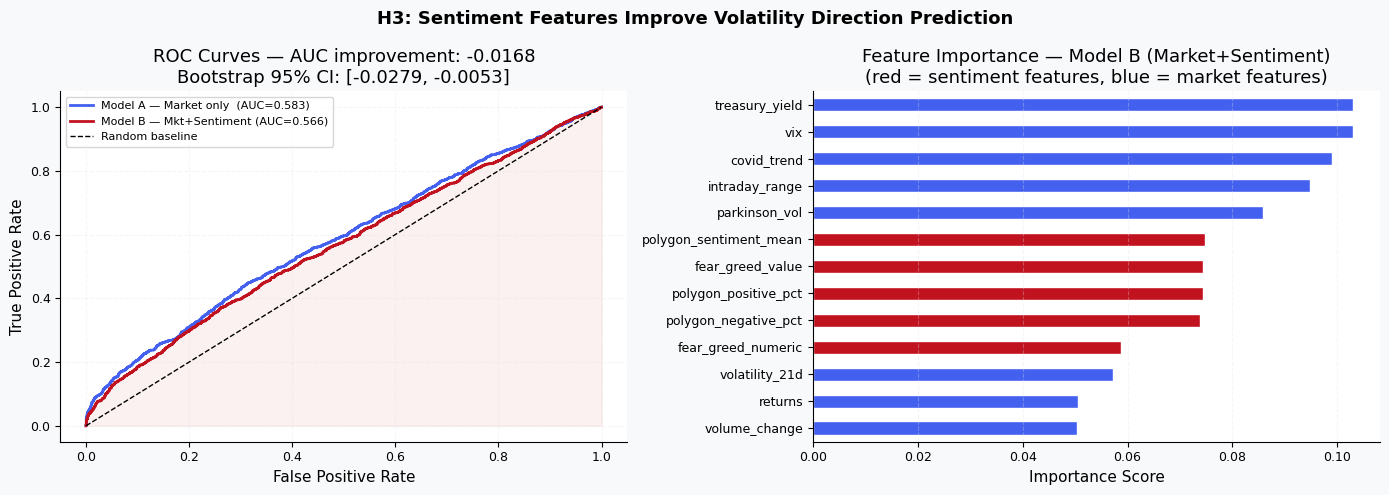

In [33]:
from sklearn.metrics import roc_curve

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('H3: Sentiment Features Improve Volatility Direction Prediction',
             fontweight='bold', fontsize=13)

ax = axes[0]
for probs, label, color, auc_val in [
    (prob_A, f'Model A — Market only  (AUC={auc_A:.3f})', PALETTE['blue'],    auc_A),
    (prob_B, f'Model B — Mkt+Sentiment (AUC={auc_B:.3f})', PALETTE['negative'], auc_B),
]:
    fpr, tpr, _ = roc_curve(y_test, probs)
    ax.plot(fpr, tpr, lw=2, color=color, label=label)
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random baseline')
ax.fill_between(*roc_curve(y_test, prob_B)[:2], alpha=0.06, color=PALETTE['negative'])
ax.set_xlabel('False Positive Rate');  ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC Curves — AUC improvement: {auc_B-auc_A:+.4f}\n'
             f'Bootstrap 95% CI: [{auc_diff_ci[0]:+.4f}, {auc_diff_ci[1]:+.4f}]')
ax.legend(fontsize=8);  ax.grid(True, alpha=0.3)

ax = axes[1]
fi = pd.Series(model_B.feature_importances_, index=all_features).sort_values(ascending=True).tail(13)
colors_fi = [PALETTE['negative'] if any(k in c for k in ['sentiment','fear','poly','neg','pos'])
             else PALETTE['blue'] for c in fi.index]
fi.plot.barh(ax=ax, color=colors_fi, edgecolor='white')
ax.set_title('Feature Importance — Model B (Market+Sentiment)\n'
             '(red = sentiment features, blue = market features)')
ax.set_xlabel('Importance Score');  ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('fig_h3_xgboost.png', dpi=150, bbox_inches='tight')
plt.show()


In [34]:
test_meta = ml_clean[ml_clean['date'] > cutoff].copy()
if 'vix' in test_meta.columns:
    vix_med_test = test_meta['vix'].median()
    test_meta['regime'] = np.where(test_meta['vix'] > vix_med_test,
                                   'High VIX (Stress)', 'Low VIX (Calm)')
    test_meta['pred_A'] = pred_A
    test_meta['pred_B'] = pred_B
    test_meta['prob_A'] = prob_A
    test_meta['prob_B'] = prob_B

    print('AUC by market regime — does sentiment help more in stress?\n')
    for regime, grp in test_meta.groupby('regime'):
        if len(grp) < 20:
            continue
        y_r = grp['vol_up']
        a_r = roc_auc_score(y_r, grp['prob_A']) if y_r.nunique() > 1 else np.nan
        b_r = roc_auc_score(y_r, grp['prob_B']) if y_r.nunique() > 1 else np.nan
        print(f'  {regime:<25}  Model A AUC={a_r:.4f}  Model B AUC={b_r:.4f}  '
              f'Δ={b_r-a_r:+.4f}  N={len(grp)}')


AUC by market regime — does sentiment help more in stress?

  High VIX (Stress)          Model A AUC=0.6210  Model B AUC=0.5869  Δ=-0.0341  N=2220
  Low VIX (Calm)             Model A AUC=0.5394  Model B AUC=0.5356  Δ=-0.0038  N=2235


In [35]:
# (placeholder — combined result already in cells 44-46)
print("H3 analysis complete, see figures above")


H3 analysis complete, see figures above


---
# Section 7 — Results Summary


In [36]:

summary = [
    {
        'Hypothesis': 'H1 — Sentiment Asymmetry',
        'Statement' : 'Negative sentiment → higher next-day Parkinson volatility than positive',
        'Method'    : 'Welch t-test + OLS (Kuuluvainen 2014)',
        'Key stats' : f't={t_stat:.3f}, p={p_ttest:.4f}, d={cohens_d:.3f}',
        'Result'    : '✅ Supported' if h1_reject else '❌ Not supported'
    },
    {
        'Hypothesis': 'H2 — Crisis Amplification',
        'Statement' : 'Asymmetric effect is stronger during high-VIX (stress) periods',
        'Method'    : 'Interaction OLS: Sent × Regime (Kuuluvainen 2014, Costola 2021)',
        'Key stats' : f'Interaction p={h2_interaction_p:.4f}',
        'Result'    : '✅ Supported' if h2_reject else '❌ Not supported'
    },
    {
        'Hypothesis': 'H3 — Predictive Value of Sentiment',
        'Statement' : 'Sentiment features improve volatility direction prediction',
        'Method'    : 'XGBoost Model A (market) vs Model B (market+sentiment)',
        'Key stats' : f'AUC A={auc_A:.3f} → B={auc_B:.3f}, Δ={auc_B-auc_A:+.3f}, CI=[{auc_diff_ci[0]:+.3f},{auc_diff_ci[1]:+.3f}]',
        'Result'    : '✅ Supported' if h3_reject else '❌ Not supported'
    },
]

res_df = pd.DataFrame(summary).set_index('Hypothesis')

def color_result(val):
    if '✅' in str(val): return 'background-color:#d4edda;color:#155724;font-weight:bold'
    if '❌' in str(val): return 'background-color:#f8d7da;color:#721c24;font-weight:bold'
    return ''

print('='*70)
print('   HYPOTHESIS TESTING — FINAL RESULTS')
print('='*70)
display(res_df.style
    .applymap(color_result, subset=['Result'])
    .set_caption('Table 6. Summary — News Sentiment & Market Volatility (2020–2025)'))


   HYPOTHESIS TESTING — FINAL RESULTS


,Statement,Method,Key stats,Result
Hypothesis,,,,
H1 — Sentiment Asymmetry,Negative sentiment → higher next-day Parkinson volatility than positive,Welch t-test + OLS (Kuuluvainen 2014),"t=2.143, p=0.0162, d=0.157",✅ Supported
H2 — Crisis Amplification,Asymmetric effect is stronger during high-VIX (stress) periods,"Interaction OLS: Sent × Regime (Kuuluvainen 2014, Costola 2021)",Interaction p=0.1143,❌ Not supported
H3 — Predictive Value of Sentiment,Sentiment features improve volatility direction prediction,XGBoost Model A (market) vs Model B (market+sentiment),"AUC A=0.583 → B=0.566, Δ=-0.017, CI=[-0.028,-0.005]",❌ Not supported


---
# Conclusion

This analysis tested three hypotheses about news sentiment and Parkinson stock market volatility using a panel of 15 major US stocks (2020–2025), with `polygon_sentiment_mean` (66,000+ financial news articles, VADER scoring) as the primary sentiment indicator.

